In [1]:


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
import gpytorch
import matplotlib.style as style
from matplotlib.lines import Line2D

palette = ["red", "blue", "green", "orange", "purple", "#AF7595", "#E6480F", "#FA9500"]
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14.0, 6)

%load_ext autoreload
%autoreload 2

import os

from loguru import logger
logger.remove()
logger.add(os.sys.stdout, colorize=True, format="<level>{time} | {message}</level>")

from voltron.likelihoods import VolatilityGaussianLikelihood
from voltron.models import SingleTaskVariationalGP
from voltron.kernels import BMKernel, VolatilityKernel
from voltron.train_utils import TrainVolModel, TrainVoltMagpieModel, LearnGPCV, TrainDataModel

Warning no robinhood utils.


## Generate Some Synthetic SDE Data

In [2]:
np.random.seed(2019)
torch.random.manual_seed(2019)

# F0 = 10 ## init price
# V0 = 0.2 ## init price
# mu = 0.05 ## rate of return

# alpha = 1.25
# beta = 0.9
# rho = -0.2

T = 1 ## Time of Simulation
steps = 400 ## steps per time. Changing this seems to mess everything up
dt = T/(steps) ## delta t

# dW = np.random.normal(0, np.sqrt(dt), steps*T)
# dZ = rho * dW + np.sqrt(1 - rho **2) * np.random.normal(0, np.sqrt(dt), steps*T)


# train_x = time = torch.linspace(0, T, steps-1) + dt
test_x = torch.linspace(T + dt, 1.5*T, int(.5*steps)-1) + dt

# Replace with real data

It should be 
- steps = 400
- full_x: a float tensor, of steps from 0 to 1
- full_y: the log returns

and note that
- F was price
- V was vol

In [3]:
import yfinance as yf
import requests_cache
# let's cache where we can
session = requests_cache.CachedSession('../data/interim/.yfinance.cache')
session.headers['User-agent'] = 'Mozilla/5.0 (Windows NT 10.0; rv:91.0) Gecko/20100101 Firefox/91.0'

ticker="SPY"
data = yf.download(tickers=ticker, session=session, period='2y', interval="1h", progress=False)
data

,Open,High,Low,Close,Adj Close,Volume
2020-07-16 09:30:00-04:00,320.089996,320.459991,319.089996,320.239990,320.239990,13359875
2020-07-16 10:30:00-04:00,320.248413,320.730011,319.339996,319.959991,319.959991,7785907
2020-07-16 11:30:00-04:00,319.970001,320.049988,319.239990,319.559998,319.559998,4407405
2020-07-16 12:30:00-04:00,319.559998,320.600006,319.510010,320.570007,320.570007,3788850
2020-07-16 13:30:00-04:00,320.579987,320.640015,319.850006,320.489990,320.489990,4713752
...,...,...,...,...,...,...
2022-07-15 12:30:00-04:00,383.850006,384.619995,383.220001,384.619995,384.619995,4992876
2022-07-15 13:30:00-04:00,384.609985,384.779999,383.713715,384.269989,384.269989,5338276
2022-07-15 14:30:00-04:00,384.279999,384.779999,384.020111,384.149994,384.149994,5918545
2022-07-15 15:30:00-04:00,383.815002,385.250000,383.600006,385.100006,385.100006,10831152


In [4]:
print(steps, len(data)-steps, len(data))
split_i = np.random.randint(steps, len(data)-steps)
print('split_i', split_i)

400 3120 3520
split_i 2818


In [5]:
ahead = test_x.shape[0]
F_all = data['Adj Close']
# F_all = d#.iloc[split_i-steps:split_i+steps]
# data_train = data_all.head(steps)
# data_test = data_all.tail(steps)

# F_s = data_train.tail(steps)['Close']
# F = F_s.values
# F_s_test = data_test['Close']

# log_returns_all = np.log(d.pct_change().iloc[split_i-steps:split_i+steps].iloc[1:]+1)
log_returns_all = np.log(F_all.pct_change()+1)
V_all = pd.Series(log_returns_all).rolling(6).std()

# restrict to our section
F_all = F_all.iloc[split_i-steps:split_i+steps].values
log_returns_all = log_returns_all.iloc[split_i-steps:split_i+steps].iloc[1:].values
V_all = V_all.iloc[split_i-steps:split_i+steps].iloc[1:].values


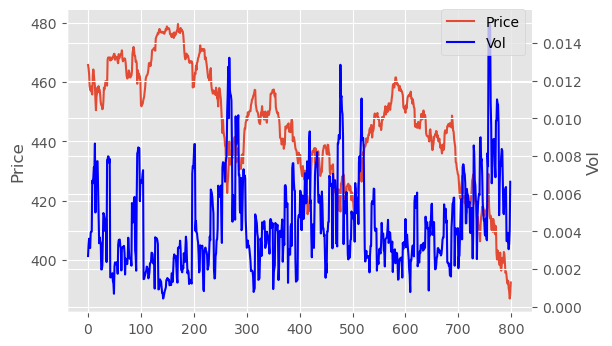

In [6]:
fig, ax = plt.subplots(dpi=100)
ax.plot(F_all, label='Price')
ax2 = ax.twinx()
ax2.plot(V_all, color = palette[1], label='Vol')

ax.set_ylabel("Price")
ax2.set_ylabel("Vol")

fig.legend(bbox_to_anchor=(0.9, 0.9))
sns.despine()
plt.show()

## Learning A Volatility Model

While we show the volatility in the plot above, we do not typically get to observe this path directly. Therefore the first step in the Volt modeling pipeline is to learn a model of the historic volatility. For this we rely on [GCPV](https://arxiv.org/abs/1006.1350).

First specify the train and test domains

In [8]:
full_x = torch.FloatTensor(np.linspace(0, T, steps-1)) + dt
full_y = torch.FloatTensor(log_returns_all[1:steps])

train_x = full_x
train_y = full_y

In [9]:
likelihood = VolatilityGaussianLikelihood(K=20, param="exp")
# likelihood.raw_a.data -= 4.
from gpytorch.constraints import Interval
covar_module = BMKernel(vol=0.99, vol_constraint=Interval(0., 10.))
# covar_module = VolatilityKernel()
model = SingleTaskVariationalGP(
    init_points=train_x.view(-1,1), likelihood=likelihood, use_piv_chol_init=False,
    mean_module = gpytorch.means.ConstantMean(), covar_module=covar_module, 
    learn_inducing_locations=False, use_whitened_var_strat=False
)
model.initialize_variational_parameters(likelihood, train_x, y=train_y)

training_iterations = 500

model.train()
likelihood.train()
optimizer = torch.optim.Adam([
    {"params": model.parameters()}, 
    # {"params": likelihood.parameters(), "lr": 0.1}
], lr=0.01)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel(), combine_terms = True)

print_every = 50
for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    with gpytorch.settings.num_gauss_hermite_locs(75):
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if i % print_every == 0:
            print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()


/media/wassname/SGIronWolf/projects5/timeseries/Volt/voltron/models/single_task_variational_gp.py:224: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352464346/work/aten/src/ATen/native/TensorShape.cpp:2981.)
  (0.5 * y.pow(-2.0) * (f * 2.0).exp()).T
/home/wassname/miniforge3/envs/volt/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352464346/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/wassname/miniforge3/envs/volt/lib/python3.7/site-packages/gp

Iter 1/500 - Loss: 21.284
Iter 51/500 - Loss: -3.832
Iter 101/500 - Loss: -4.029
Iter 151/500 - Loss: -4.040
Iter 201/500 - Loss: -4.041
Iter 251/500 - Loss: -4.041
Iter 301/500 - Loss: -4.041
Iter 351/500 - Loss: -4.041
Iter 401/500 - Loss: -4.041
Iter 451/500 - Loss: -4.041


In [10]:
model.eval()
likelihood.eval()
predictive = model(full_x)
# FIXME I use max instead of min, because the model was not capturing vol spikes
pred_scale = likelihood(predictive, return_gaussian=False).scale.mean(0).detach()
# pred_scale = likelihood(predictive, return_gaussian=False).scale.max(0)[0].detach()

we really need to capture the max spikes or we wont have a good model


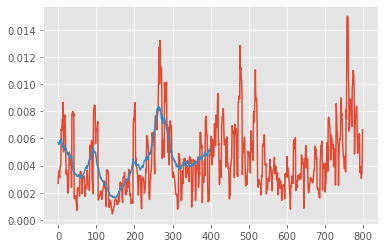

In [11]:
print("we really need to capture the max spikes or we wont have a good model")
plt.plot(V_all)
plt.plot(pred_scale)


## Now Train the Volt Model

Given the GCPV volatility path we can now train a GP over the historic volatility, and then learn the final Volt model to forecast with.

In [12]:
# vmod, vlh = TrainVolModel(train_x, pred_scale, kernel="bm", train_iters=500, printing=True)
vmod, vlh = TrainVolModel(train_x, pred_scale, kernel="fbm", vol=0.99, vol_constraint=Interval(0., 30.), train_iters=500, printing=True)
# vmod, vlh = TrainVolModel(train_x, pred_scale, kernel="bm", vol=0.99, vol_constraint=Interval(0., 30.), train_iters=500, printing=True)

Iter 1/500 - Loss: 5.577
Iter 51/500 - Loss: 4.335
Iter 101/500 - Loss: 3.660
Iter 151/500 - Loss: 3.236
Iter 201/500 - Loss: 2.932
Iter 251/500 - Loss: 2.694
Iter 301/500 - Loss: 2.499
Iter 351/500 - Loss: 2.334
Iter 401/500 - Loss: 2.190
Iter 451/500 - Loss: 2.059


In [13]:
# plt.plot(pred_scale)

In [14]:
F = F_all[:steps]
V = V_all[:steps]
dmod, dlh = TrainDataModel(train_x, torch.FloatTensor(F)[1:], vmod, vlh, pred_scale)

## Sampling

We now have a trained data model which is the main Volt class. To forecast we specify how many volatility paths we want to draw, `nvol`, and how many price paths we want to draw for each volatility path, `npx`. Then we simply loop through and draw the corresponding samples using the `GeneratePrediction` method.

In [15]:
dmod.eval();
dlh.eval();
dmod.vol_model.eval();

nvol = 60
npx = 1
px_paths = torch.zeros(npx*nvol, test_x.shape[0])
vol_paths = torch.zeros(nvol, test_x.shape[0])

for vidx in range(nvol):
#     print(vidx)
    vol_pred = dmod.vol_model(test_x).sample().exp()
    vol_paths[vidx, :] = vol_pred.detach()
    
    # FIXME hack, I don't know why I need the x10 here
    px_pred = dmod.GeneratePrediction(test_x, vol_pred*10, npx).exp()
    px_paths[vidx*npx:(vidx*npx + npx), :] = px_pred.detach().T

px_paths.shape

torch.Size([60, 199])

## Put It All Together

Below we plot the full hierarchy - the learned volatility path, the predicted volatility paths into the future, and the predicted paths conditioned on the predicted volatility paths.

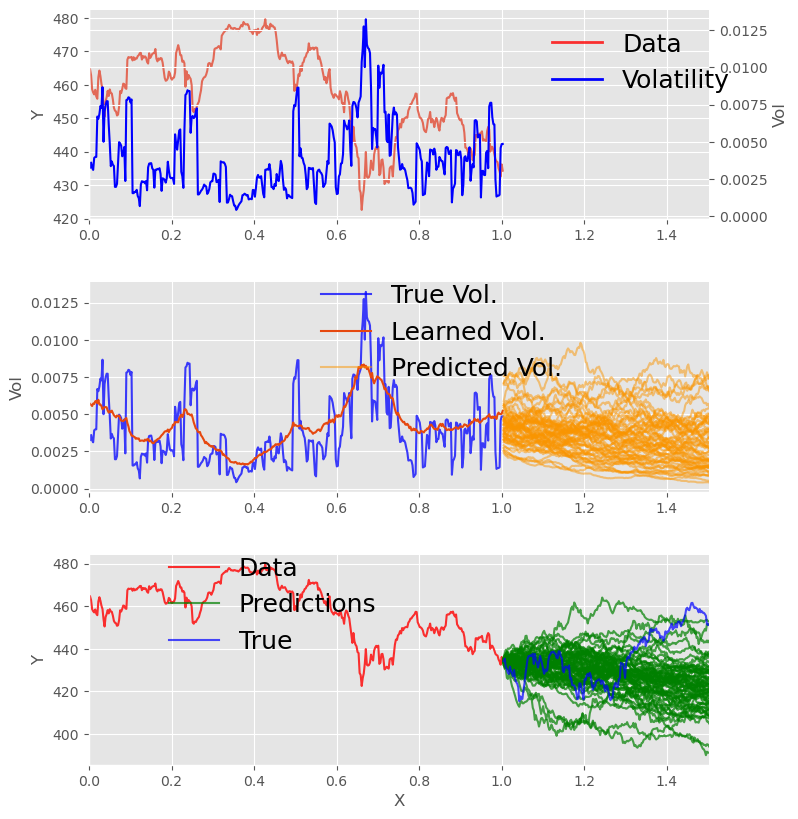

In [16]:
def FormatAx(ax):
    ax.set_xlim(0, test_x.max())
#     ax.axvline(train_time.max(), ls="--", c='k', lw=0.5)

fig, ax = plt.subplots(3, 1, figsize = (8, 10), dpi=100, facecolor = "w")
plt.subplots_adjust(hspace=0.3)

## vol & log return plot ##
ax[0].plot(train_x, F[1:], label='Data', alpha=0.8)
ax2 = ax[0].twinx()
ax2.plot(train_x, V[1:], color = palette[1], label='Volatility')
ax[0].set_ylabel("Y")
ax2.set_ylabel("Vol")
# ax[0].legend(bbox_to_anchor=(0.9, 0.9))

custom_lines = [Line2D([0], [0], color=palette[0], lw=2., alpha=0.8,label="Data"),
                Line2D([0], [0], color=palette[1], lw=2., label="Volatility")]

ax[0].legend(handles=custom_lines,loc="upper right", bbox_to_anchor=(1.07, 1.), 
             frameon=False, fontsize=18)


## Vol and Forecast Plot ##
ax[1].plot(train_x, V[1:], color = palette[1], alpha=0.75, label="True Vol.")
ax[1].plot(train_x, pred_scale, color = palette[-2], label = "Learned Vol.")
ax[1].plot(test_x, vol_paths[0, :].T, color=palette[-1], alpha=0.5, label="Predicted Vol.")
ax[1].plot(test_x, vol_paths[1:, :].T, color=palette[-1], alpha=0.5)
ax[1].set_ylabel("Vol")
ax[1].legend(loc="upper right", bbox_to_anchor=(0.8, 1.1), frameon=False, fontsize=18)

## Price and Forecast Plot ##
ax[2].plot(train_x, F[1:], color=palette[0], alpha=0.8, label="Data")
ax[2].plot(test_x, px_paths[1:, :].T, color=palette[2], alpha=0.7)
ax[2].plot(test_x, px_paths[0, :].T, color=palette[2], alpha=0.7, label="Predictions")
# s=px_paths.std(0)
# m=px_paths.mean(0)
# ax[2].fill_between(test_x, m-s, m+s, alpha=0.2, color=palette[2])

F_s_test = F_all[steps:steps+steps//2-1]
ax[2].plot(test_x, F_s_test, color=palette[1], alpha=0.7, label="True")


# ax[2].plot(F_all.values, color=palette[1], alpha=0.7, label="True")

ax[2].set_ylabel("Y")
ax[2].set_xlabel("X")
ax[2].legend(loc="upper right", bbox_to_anchor=(0.5, 1.1), frameon=False, fontsize=18)
## General Adjustments ##
FormatAx(ax[0])
FormatAx(ax[1])
FormatAx(ax[2])

sns.despine()
plt.show()

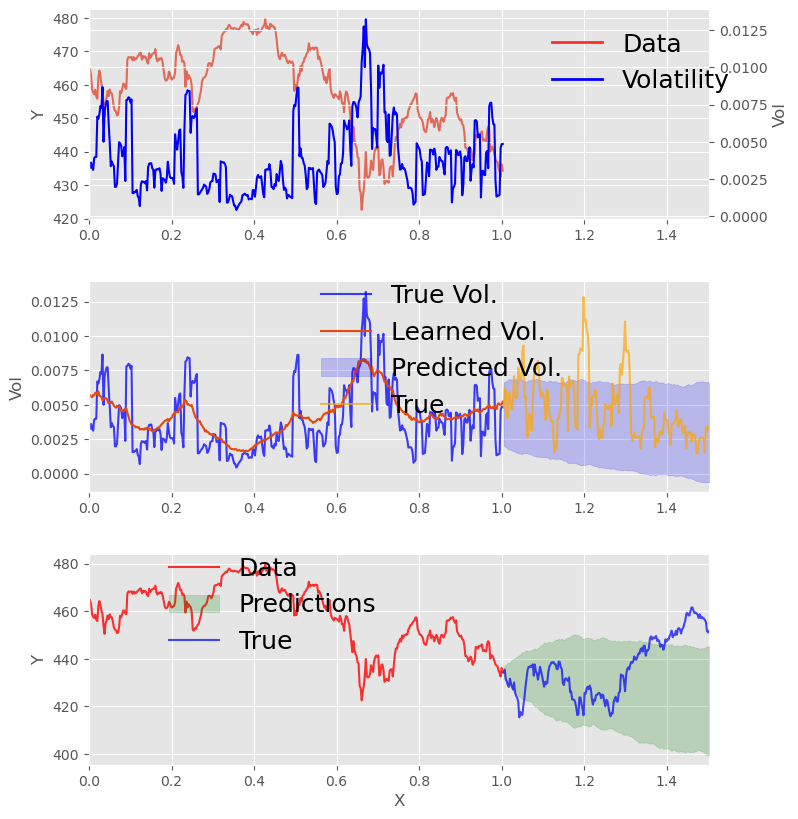

In [17]:
def FormatAx(ax):
    ax.set_xlim(0, test_x.max())
#     ax.axvline(train_time.max(), ls="--", c='k', lw=0.5)

fig, ax = plt.subplots(3, 1, figsize = (8, 10), dpi=100, facecolor = "w")
plt.subplots_adjust(hspace=0.3)

## vol & log return plot ##
ax[0].plot(train_x, F[1:], label='Data', alpha=0.8)
ax2 = ax[0].twinx()
ax2.plot(train_x, V[1:], color = palette[1], label='Volatility')
ax[0].set_ylabel("Y")
ax2.set_ylabel("Vol")
# ax[0].legend(bbox_to_anchor=(0.9, 0.9))

custom_lines = [Line2D([0], [0], color=palette[0], lw=2., alpha=0.8,label="Data"),
                Line2D([0], [0], color=palette[1], lw=2., label="Volatility")]

ax[0].legend(handles=custom_lines,loc="upper right", bbox_to_anchor=(1.07, 1.), 
             frameon=False, fontsize=18)


## Vol and Forecast Plot ##
ax[1].plot(train_x, V[1:], color = palette[1], alpha=0.75, label="True Vol.")
ax[1].plot(train_x, pred_scale, color = palette[-2], label = "Learned Vol.")
# ax[1].plot(test_x, vol_paths[0, :].T, color=palette[-1], alpha=0.5, label="Predicted Vol.")
# ax[1].plot(test_x, vol_paths[1:, :].T, color=palette[-1], alpha=0.5)
s=vol_paths.std(0)
m=vol_paths.mean(0)
ax[1].fill_between(test_x, m-s*2, m+s*2, alpha=0.2, color=palette[1], label="Predicted Vol.")


V_s_test = V_all[steps:steps+steps//2-1]
ax[1].plot(test_x, V_s_test, color=palette[3], alpha=0.7, label="True")

ax[1].set_ylabel("Vol")
ax[1].legend(loc="upper right", bbox_to_anchor=(0.8, 1.1), frameon=False, fontsize=18)

## Price and Forecast Plot ##
ax[2].plot(train_x, F[1:], color=palette[0], alpha=0.8, label="Data")
# ax[2].plot(test_x, px_paths[1:, :].T, color=palette[2], alpha=0.7)
# ax[2].plot(test_x, px_paths[0, :].T, color=palette[2], alpha=0.7, label="Predictions")
s=px_paths.std(0)
m=px_paths.mean(0)
ax[2].fill_between(test_x, m-s*2, m+s*2, alpha=0.2, color=palette[2], label="Predictions")

F_s_test = F_all[steps:steps+steps//2-1]
ax[2].plot(test_x, F_s_test, color=palette[1], alpha=0.7, label="True")


# ax[2].plot(F_all.values, color=palette[1], alpha=0.7, label="True")

ax[2].set_ylabel("Y")
ax[2].set_xlabel("X")
ax[2].legend(loc="upper right", bbox_to_anchor=(0.5, 1.1), frameon=False, fontsize=18)
## General Adjustments ##
FormatAx(ax[0])
FormatAx(ax[1])
FormatAx(ax[2])

sns.despine()
plt.show()

## Note:

There are some helpful utilities for training and forecasting that are used in the experimental code - we encourage you to play around with these utilities and try out Volt on new problems!